# Import Libraries

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import *
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam

# Data Preprocessing

In [2]:
train_image_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Kvasir_SEG_Training_880/image'
train_mask_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Kvasir_SEG_Training_880/mask'
val_image_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Kvasir_SEG_Validation_120/images'
val_mask_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Kvasir_SEG_Validation_120/masks'

# Training set
train_images = utils.image_dataset_from_directory(
    train_image_dir, label_mode=None, batch_size=16,
    image_size=(128, 128), shuffle=False
)
train_masks = utils.image_dataset_from_directory(
    train_mask_dir, label_mode=None, batch_size=16,
    image_size=(128, 128), shuffle=False, color_mode='grayscale'
)
train_ds = tf.data.Dataset.zip((train_images, train_masks)).map(
    lambda x, y: (x / 255.0, y / 255.0)
)

# Validatation set
val_images = utils.image_dataset_from_directory(
    val_image_dir, label_mode=None, batch_size=16,
    image_size=(128, 128), shuffle=False
)
val_masks = utils.image_dataset_from_directory(
    val_mask_dir, label_mode=None, batch_size=16,
    image_size=(128, 128), shuffle=False, color_mode='grayscale'
)
val_ds = tf.data.Dataset.zip((val_images, val_masks)).map(
    lambda x, y: (x / 255.0, y / 255.0)
)

Found 880 files belonging to 1 classes.
Found 880 files belonging to 1 classes.
Found 120 files belonging to 1 classes.
Found 120 files belonging to 1 classes.


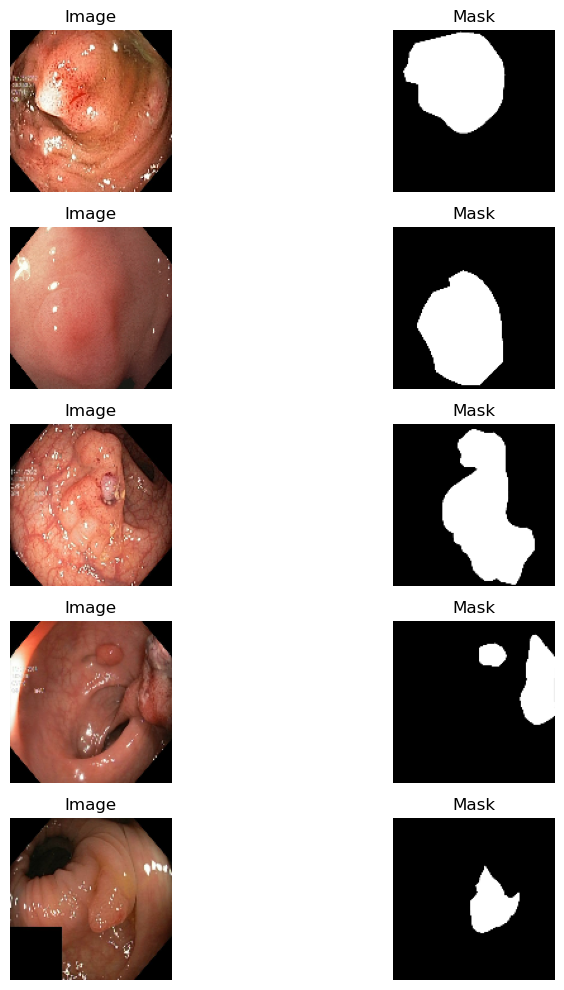

In [3]:
# Select a few images to plot
num_images = 5
sample_images, sample_masks = next(train_ds.as_numpy_iterator())
sample_images = sample_images[:num_images]
sample_masks = sample_masks[:num_images]

# Plot the images and masks
fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))

for i, (image, mask) in enumerate(zip(sample_images, sample_masks)):
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image')

    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Mask')

plt.tight_layout()
plt.show()

# Define and train model

In [4]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.conv_0 = layers.Conv2D(filters, 1, strides, 'same')
        self.conv_1 = layers.Conv2D(filters, kernel_size, strides, 'same')
        self.batch_norm_1 = layers.BatchNormalization()
        self.relu_1 = layers.ReLU()
        self.conv_2 = layers.Conv2D(filters, kernel_size, strides, 'same')
        self.batch_norm_2 = layers.BatchNormalization()
        self.add = layers.Add()
        self.relu_2 = layers.ReLU()

    def call(self, x):
        res = self.conv_0(x)
        x = self.conv_1(x)
        x = self.batch_norm_1(x)
        x = self.relu_1(x)
        x = self.conv_2(x)
        x = self.add([x, res])
        x = self.batch_norm_2(x)
        x = self.relu_2(x)
        return x

In [5]:
# Define the U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Downsample path
    conv1 = ResidualBlock(64, 3)(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ResidualBlock(128, 3)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ResidualBlock(256, 3)(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ResidualBlock(512, 3)(pool3)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bridge
    conv5 = ResidualBlock(1024, 3)(pool4)
    drop5 = Dropout(0.5)(conv5)

    # Upsample path
    up6 = ResidualBlock(512, 3)(UpSampling2D(size=(2, 2))(drop5))
    conv6 = concatenate([drop4, up6], axis=3)

    up7 = ResidualBlock(256, 3)(UpSampling2D(size=(2, 2))(conv6))
    conv7 = concatenate([conv3, up7], axis=3)

    up8 = ResidualBlock(128, 3)(UpSampling2D(size=(2, 2))(conv7))
    conv8 = concatenate([conv2, up8], axis=3)

    up9 = ResidualBlock(64, 2)(UpSampling2D(size=(2, 2))(conv8))
    conv9 = concatenate([conv1, up9], axis=3)
    conv9 = ResidualBlock(32, 3)(conv9)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
# Define the model architecture
input_shape = (128, 128, 3)  # Adjust input shape based on your image size and channels
model = unet_model(input_shape)
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00045), loss='binary_crossentropy', metrics=['binary_accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 residual_block (ResidualBlock)  (None, 128, 128, 64  39488      ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 64)   0           ['residual_block[0][0]']         
                                                                                              

In [13]:
# Train the model
model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
55/55 [==============================] - 12s 224ms/step - loss: 0.1439 - binary_accuracy: 0.9412 - val_loss: 0.3280 - val_binary_accuracy: 0.8929
Epoch 2/50
55/55 [==============================] - 12s 226ms/step - loss: 0.1278 - binary_accuracy: 0.9474 - val_loss: 0.2807 - val_binary_accuracy: 0.9083
Epoch 3/50
55/55 [==============================] - 12s 222ms/step - loss: 0.1240 - binary_accuracy: 0.9486 - val_loss: 0.2634 - val_binary_accuracy: 0.8985
Epoch 4/50
55/55 [==============================] - 12s 226ms/step - loss: 0.1125 - binary_accuracy: 0.9526 - val_loss: 0.2736 - val_binary_accuracy: 0.8974
Epoch 5/50
55/55 [==============================] - 12s 223ms/step - loss: 0.1013 - binary_accuracy: 0.9567 - val_loss: 0.5248 - val_binary_accuracy: 0.8174
Epoch 6/50
55/55 [==============================] - 12s 225ms/step - loss: 0.0996 - binary_accuracy: 0.9565 - val_loss: 0.4063 - val_binary_accuracy: 0.8498
Epoch 7/50
55/55 [==============================] - 12s 22

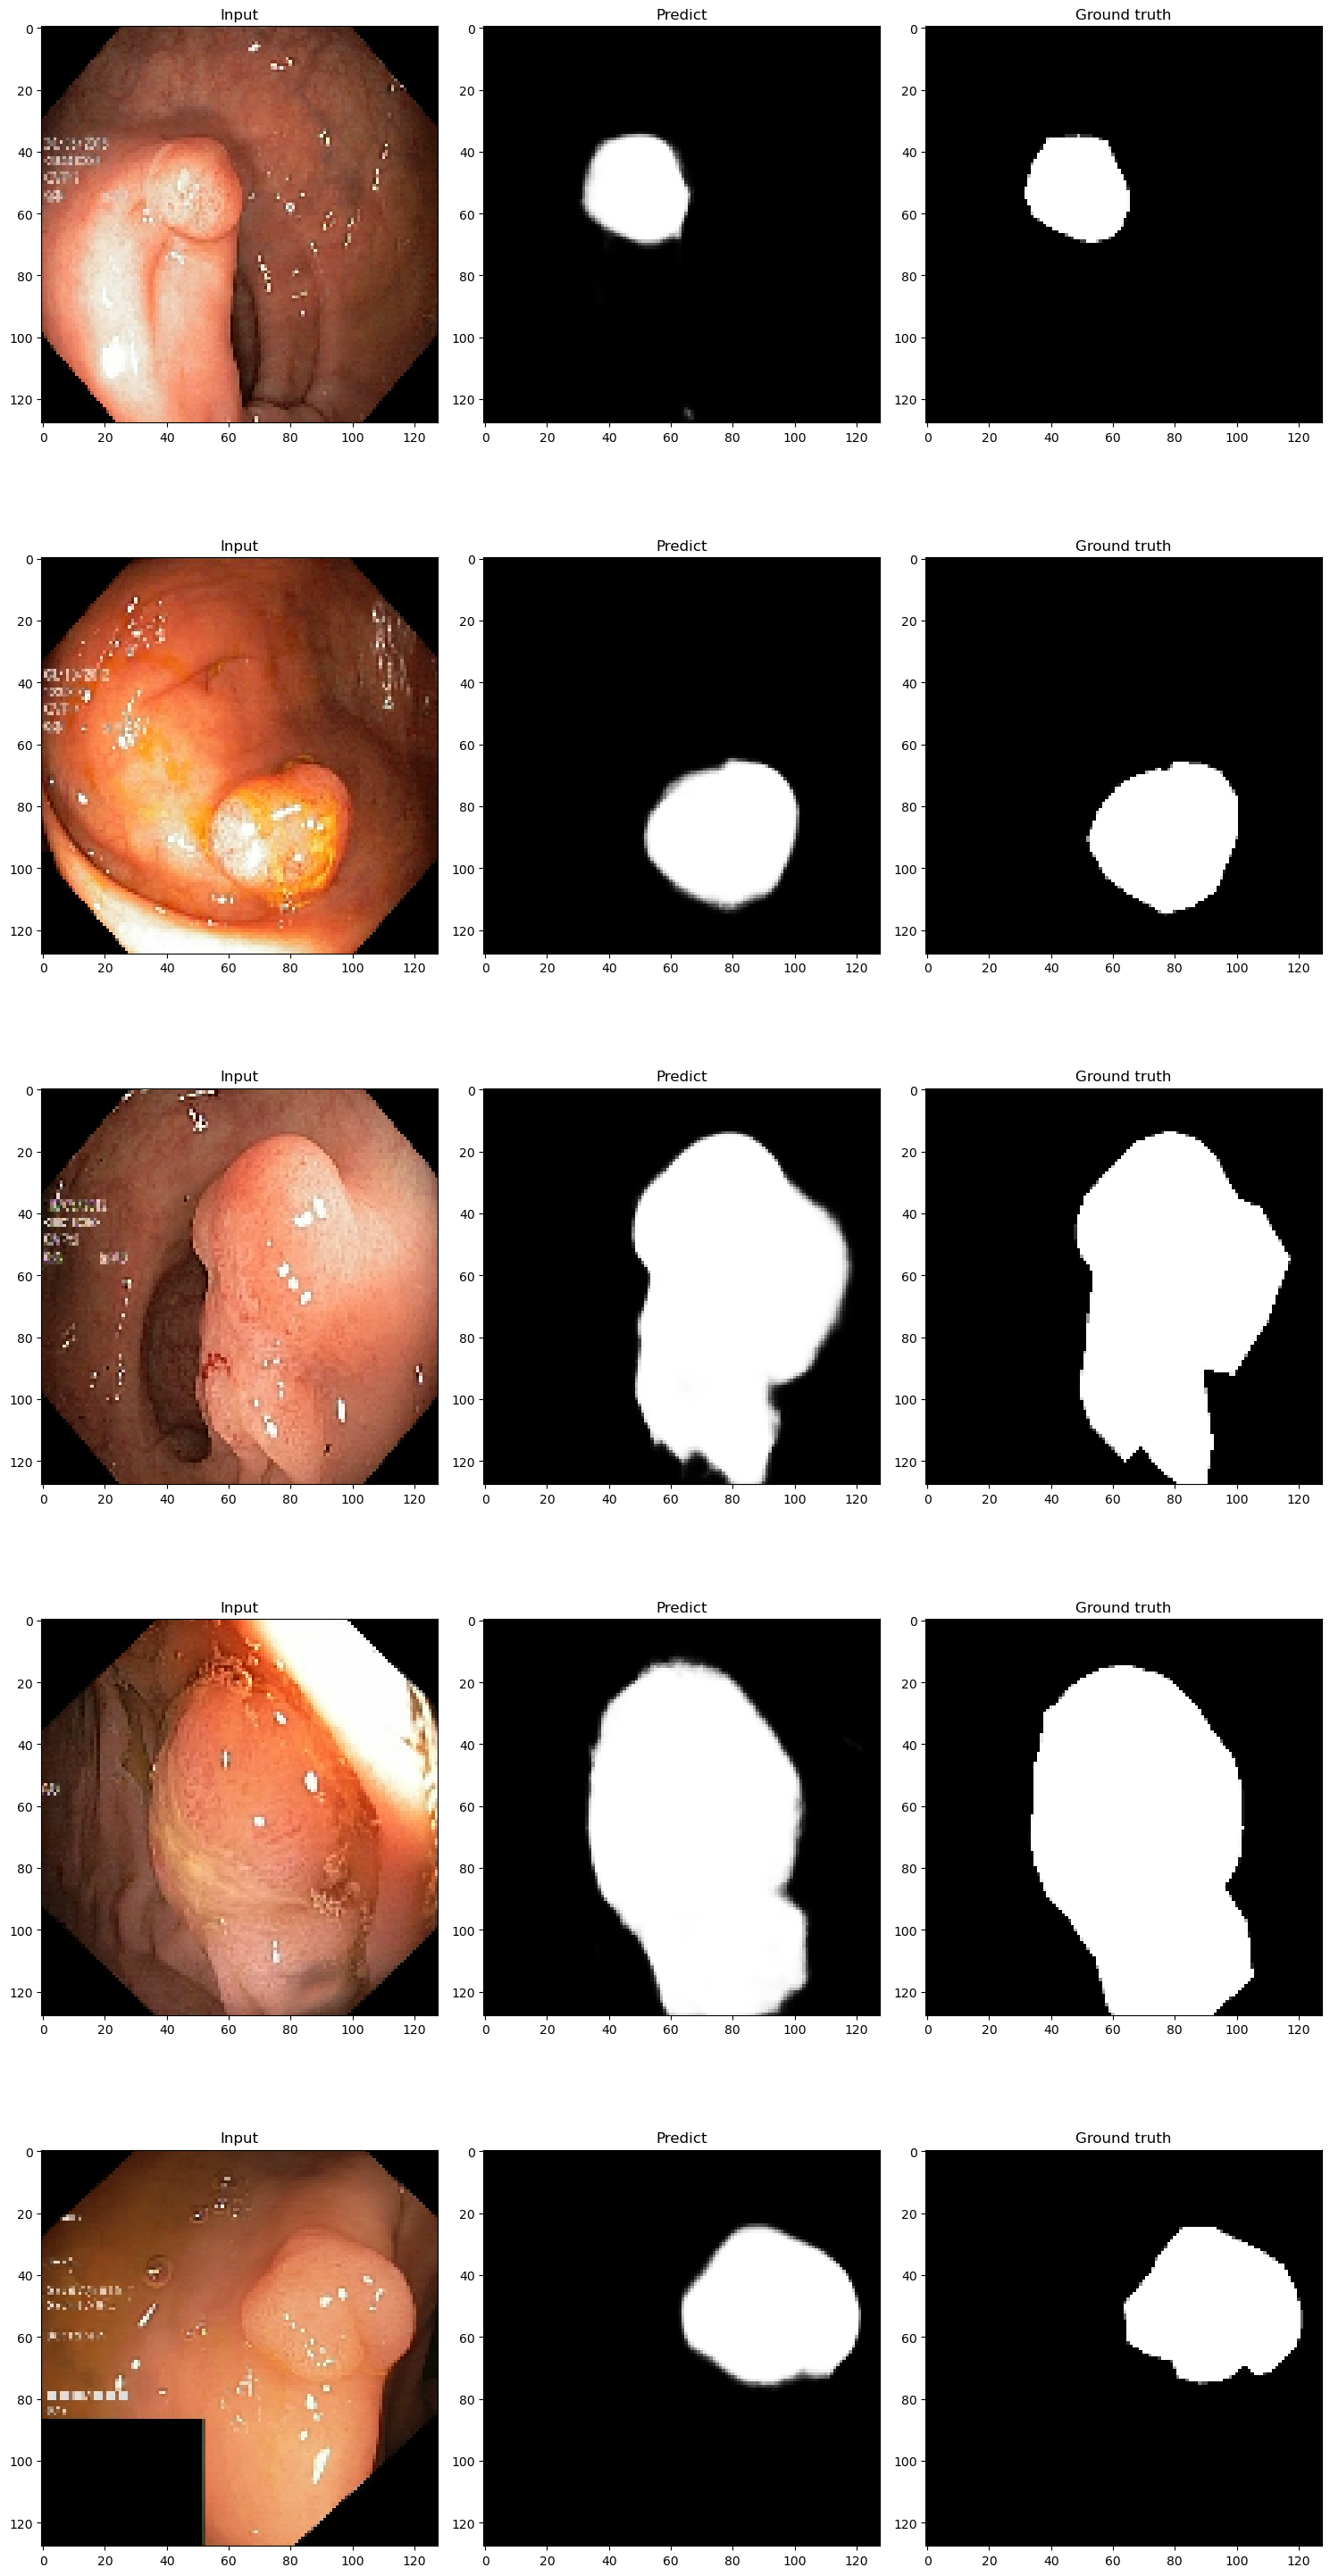

In [14]:
num_images = 5

# Plot training result
fig, axes = plt.subplots(num_images, 3, figsize=(15, 6*num_images))

for i in range(num_images):
    x, y = next(train_ds.shuffle(100).as_numpy_iterator())
    x, y = x[:1], y[:1]
    pred = model(x)
    
    # Plot the input image
    axes[i][0].set_title('Input')
    axes[i][0].imshow(x[0], cmap='gray')
    
    # Plot the predicted output
    axes[i][1].set_title('Predict')
    axes[i][1].imshow(pred[0], cmap='gray')
    
    # Plot the ground truth mask
    axes[i][2].set_title('Ground truth')
    axes[i][2].imshow(y[0], cmap='gray')

plt.tight_layout()
plt.show()

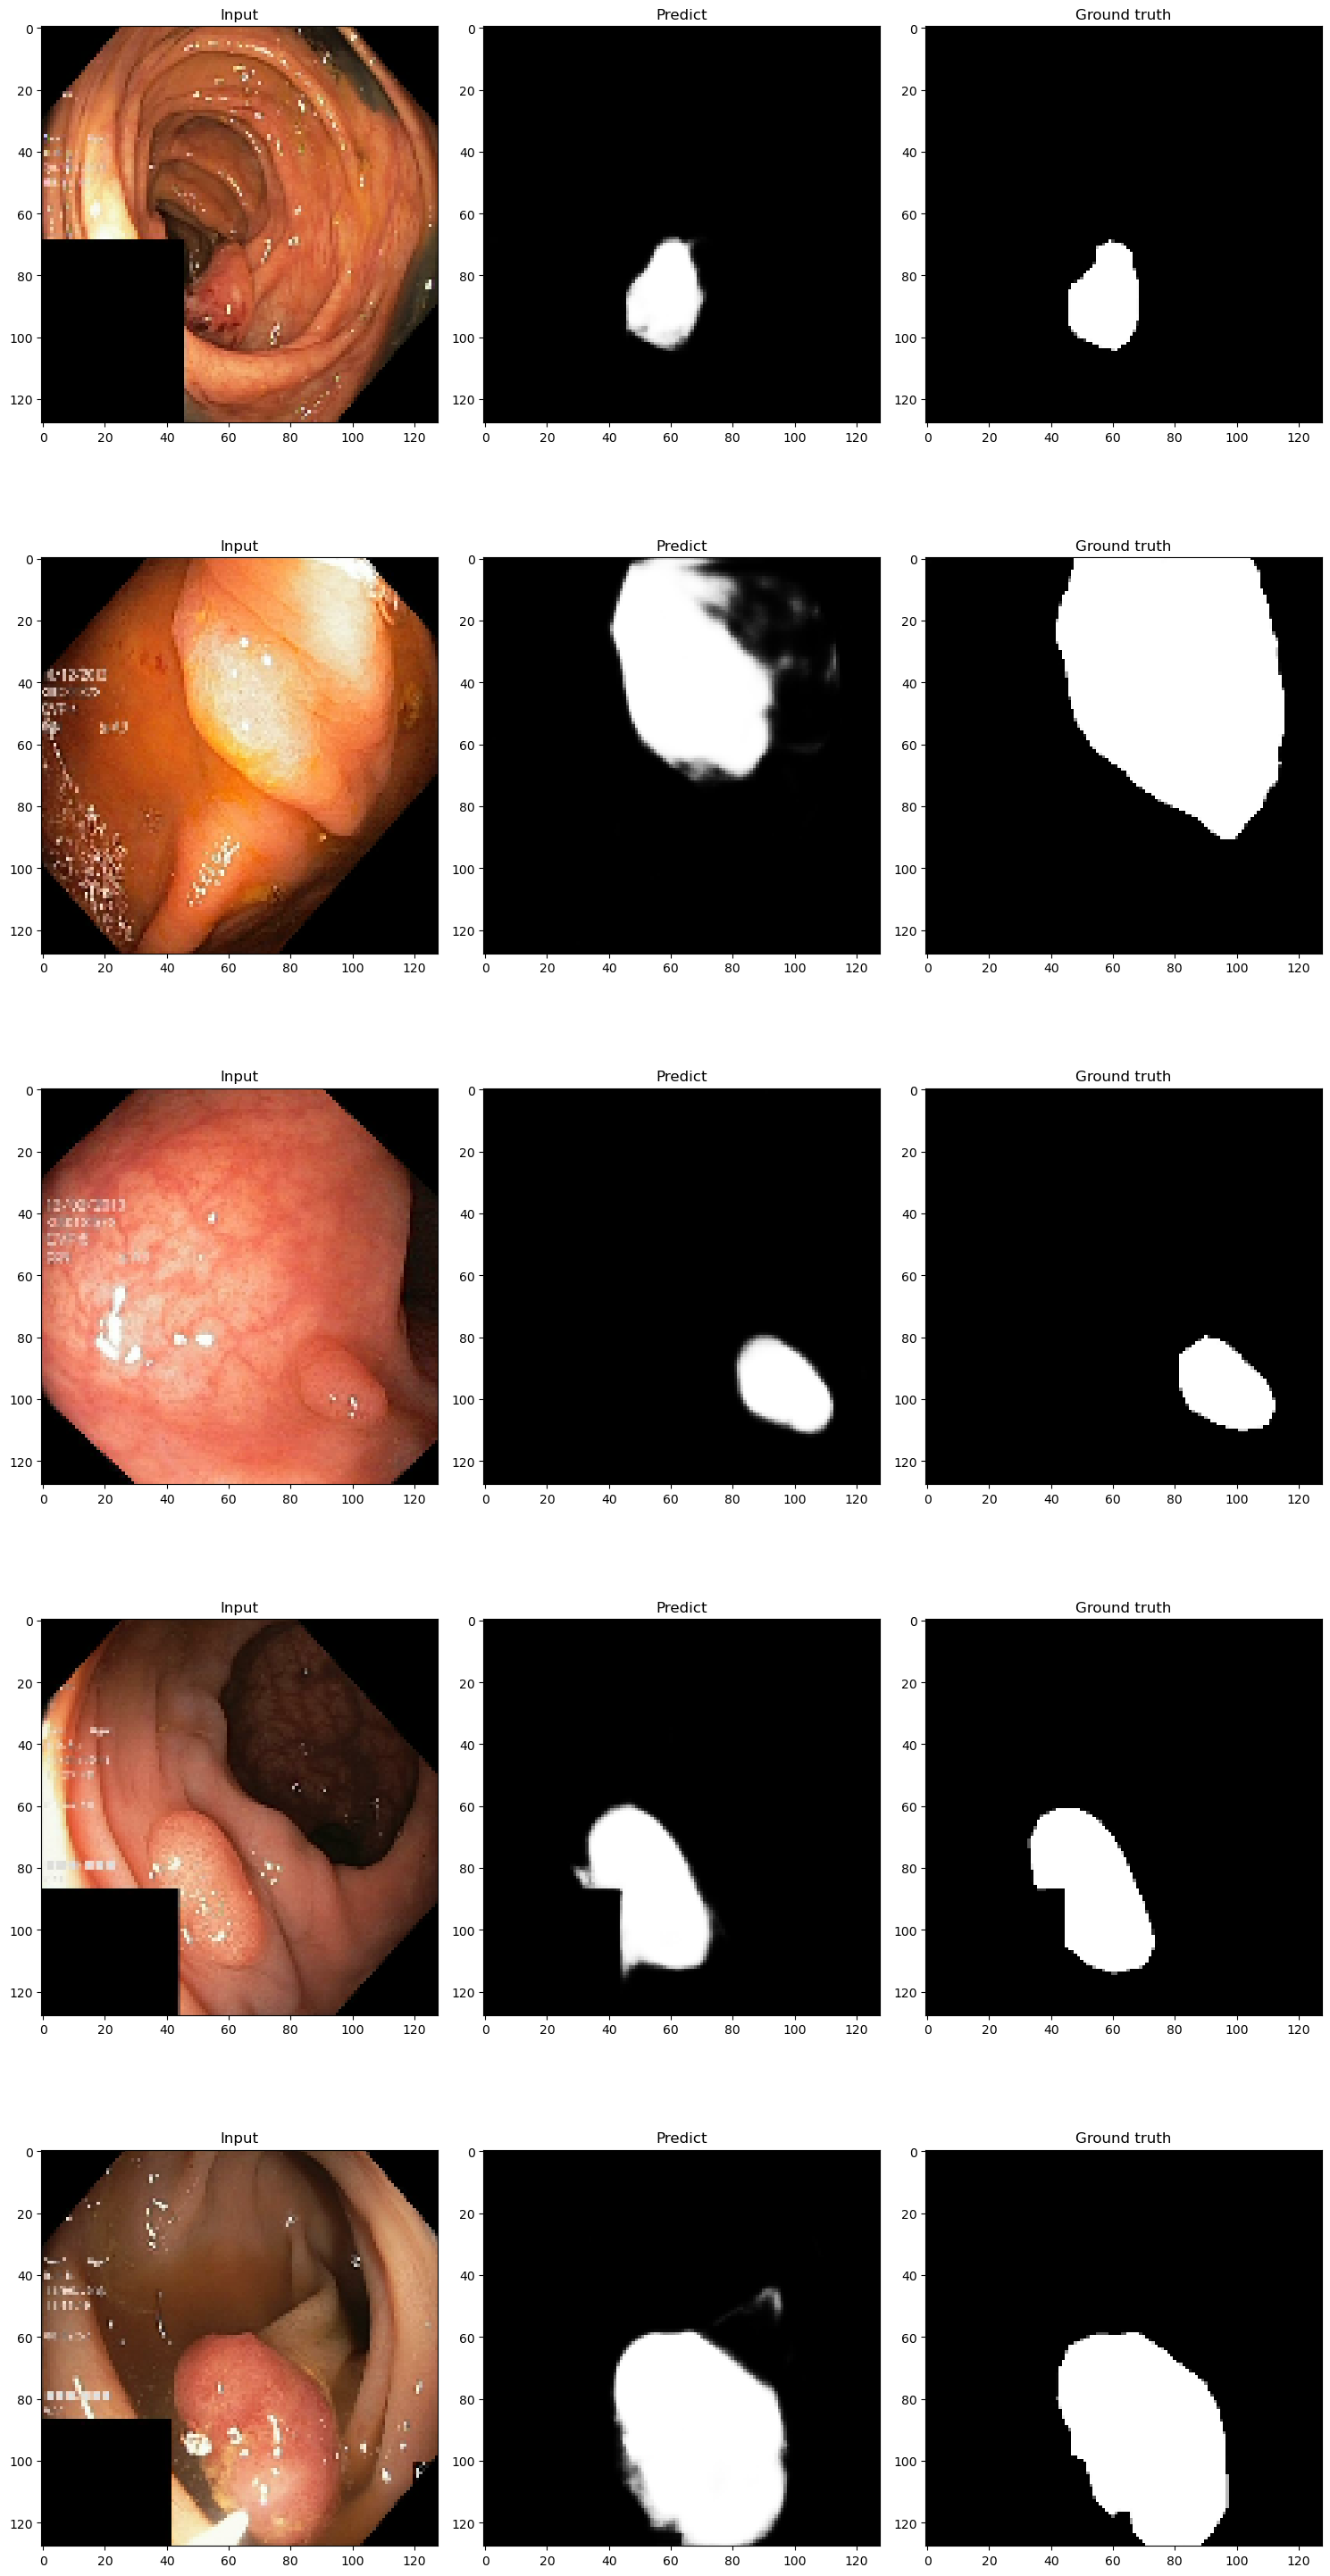

In [15]:
fig, axes = plt.subplots(num_images, 3, figsize=(15, 6*num_images))
val_iterator = iter(val_ds)
for i in range(num_images):
    x_val, y_val = next(val_iterator)
    x_val, y_val = x_val[:1], y_val[:1]
    pred_val = model(x_val)
    
    # Plot the input image
    axes[i][0].set_title('Input')
    axes[i][0].imshow(x_val[0], cmap='gray')
    
    # Plot the predicted output
    axes[i][1].set_title('Predict')
    axes[i][1].imshow(pred_val[0], cmap='gray')
    
    # Plot the ground truth mask
    axes[i][2].set_title('Ground truth')
    axes[i][2].imshow(y_val[0], cmap='gray')

plt.tight_layout()
plt.show()

In [17]:
# Save the trained model
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Weights/unet_model_weight_gg.h5')